In [39]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import os
import torch.utils.data
import torch.optim as optim
from torch.autograd import Variable as V
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torch.nn import functional as F
import numpy as np
from torchvision.utils import save_image
%matplotlib inline
cuda = torch.cuda.is_available()
if cuda:
    print('cuda is available!')

if not os.path.exists("save_image"):
    os.mkdir("save_image")
if not os.path.exists("dataset"):
    os.mkdir("dataset")


mnist_train=MNIST("dataset",train=True,download=True, transform=transforms.ToTensor())
mnist_test=MNIST("dataset",train=False,download=True, transform=transforms.ToTensor())
train_loader=DataLoader(mnist_train,batch_size=32,shuffle=True)
test_loader=DataLoader(mnist_test,batch_size=32,shuffle=False)


print(len(train_loader)) #60000/batch_size
print(len(test_loader)) #10000/batch_size

1875
313


torch.Size([32, 1, 28, 28])


Text(0.5,1,'Label=8')

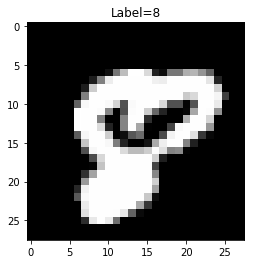

In [40]:
data_iter=iter(train_loader)
images,labels=data_iter.next()
print(images.size())
image=images[0].numpy() #(1,28,28)
image=image.reshape(28,28)
plt.imshow(image,cmap="gray")
plt.title("Label={}".format(labels[0]))

In [41]:
class Encoder(nn.Module):
    def __init__(self,input_channels,hidden_size):
        super(Encoder,self).__init__()
        self.input_channels=input_channels
        self.hidden_size=hidden_size
        #(1,28,28)
        self.encode=nn.Sequential(

            nn.Conv2d(self.input_channels,16,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #(16,14,14)

            nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #(32,7,7)

            nn.Conv2d(32,64,kernel_size=2,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
            #(64,4,4)
        
        self.mean=nn.Sequential(
            nn.Linear(64*4*4,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024,hidden_size))       
        self.logvar=nn.Sequential(
            nn.Linear(64*4*4,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024,hidden_size))
            
    def forward(self,x):
        batch_size=x.size()[0]
        encoding=self.encode(x)
        mean=self.mean(encoding.view(batch_size,-1))
        logvar=self.logvar(encoding.view(batch_size,-1))
        
        return mean,logvar
    
    def encode_layer(self,x):
        batch_size=x.size()[0]
        output=self.encode(x)
        
        return output
        
class Decoder(nn.Module):
    def __init__(self,hidden_size):
        super(Decoder,self).__init__()
        self.hidden_size=hidden_size
        
        self.pre=nn.Sequential(
            nn.Linear(hidden_size,64*4*4),
            nn.BatchNorm1d(64*4*4),
            nn.ReLU())
        
        self.decode=nn.Sequential(
            #(64,4,4)
            nn.ConvTranspose2d(64,32,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #(32,7,7)
            
            nn.ConvTranspose2d(32,16,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            #(16,14,14)
            
            nn.ConvTranspose2d(16,8,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            
            #(8,28,28),
            
            nn.ConvTranspose2d(8,1,kernel_size=3,stride=1,padding=1),
            nn.Sigmoid())
        
    def forward(self,code):
        #batch_size=code.size()[0]
        preprocess=self.pre(code)
        preprocess=preprocess.view(-1,64,4,4)
            
        out=self.decode(preprocess)
        return out
            
        
        
class VAE(nn.Module):
    def __init__(self,input_channels,hidden_size):
        super(VAE,self).__init__()
        self.input_channles=input_channels
        self.hidden_size=hidden_size
        self.encoder=Encoder(input_channels,hidden_size)
        self.decoder=Decoder(hidden_size)
        
    def forward(self,x):
        batch_size=x.size()[0]
        mean,logvar=self.encoder(x)
        std=logvar.mul(0.5).exp_()
        
        noise=V(torch.randn((batch_size,self.hidden_size)))
        if cuda:
            noise=noise.cuda()
        noise=mean+std*noise
            
        decode_image=self.decoder(noise)
        decode_image=decode_image.view(-1,784)
        
        return mean,logvar,decode_image
        

In [42]:
if cuda:
    param=torch.load("asset/vae.pth")
else:
    param=torch.load("asset/vae.pth",map_location=lambda storage, loc:storage)
model=VAE(1,32)
model.load_state_dict(param)

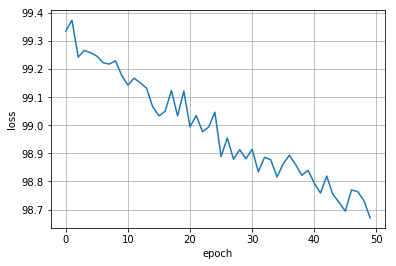

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
loss_list = np.load('asset/loss_list.npy')
plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

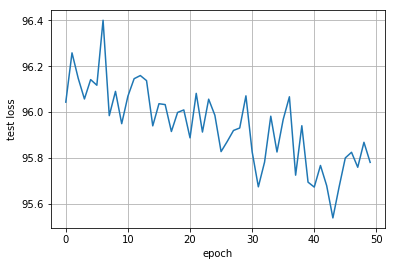

In [44]:
test_loss_list = np.load('asset/test_loss_list.npy')
plt.plot(test_loss_list)
plt.xlabel('epoch')
plt.ylabel('test loss')
plt.grid()

torch.Size([32, 784])


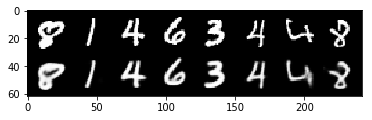

In [45]:
mean,logvar,decode_images=model(images)
print(decode_images.size())
inspect_image=torch.cat([images[:8],decode_images.view(32,1,28,28)[:8]])

save_image(inspect_image.data.cpu(),"save_image/save.png",nrow=8)

img=plt.imread("save_image/save.png")
plt.imshow(img)